In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
#from labml import tracker, experiment
from sklearn.metrics import f1_score

import numpy as np
import os, shutil

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [302]:
# Hyperparameters
num_epochs = 10 #how many of training cycles to run?
batch_size = 100 #how many records at one time?
learning_rate = 0.001 # how fast can you learn? size of the learning step?

In [266]:
# CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [268]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [269]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [272]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [274]:
# graph setup with labml
#experiment.create(name="CIFAR_CIFAKE", comment="Test")

In [276]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [55]:
#TARGETS train_loader.dataset.targets

In [278]:
x = [tl for idx, tl in enumerate(train_loader) if idx == 240][0]
images, labels = x
print(len(images))
print(len(labels))

100
100


In [280]:
# Define CNN architectures
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [282]:
# Select the model
#model = SimpleCNN().to(device)
model = DeepCNN().to(device)

In [284]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [304]:
# Function for TRAINING and TESTING the model
#Training the model
def train_model(model, train_loader):
    model.train()
    loss_list = []
    #prob_list = []
    f1_score_train = []
    f1_score_test = []
    #with experiment.record(name = "CIFAR_CIFAKE"):
    for epoch in range(num_epochs):
        #print("epoch " + str(epoch))
        running_loss = 0.0
        #non_avg_running_loss = 0.0
        #prob_list_epch = []
        f1_score_epch = []
        for i, (images, labels) in enumerate(train_loader):
            #print("batch " + str(i))
            images, labels = images.to(device), labels.to(device)
            #labels are the actual values of the images

            # Forward pass
            outputs = model(images)
            #outputs are the logits of the predicted values of the images 

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #non_avg_runing_loss += loss.item()

            if (i+1) % 500 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/500:.4f}")
                #loss_list.append(running_loss/500)
                running_loss = 0.0

            _, pred_class = torch.max(outputs, dim=1)
            #pred_class is the predicted classes for the images in this batch

            f1_score_btch = f1_score(labels.numpy(), pred_class.numpy(), average='weighted')
            #print(f"F1 score for batch {i}, epoch {epoch}: {f1_score_btch}")
            f1_score_epch.append(f1_score_btch)
            
        print(np.array(f1_score_epch).shape)
        f1_score_train.append(f1_score_epch)
        
        test_f1 = test_model(model, test_loader)
        f1_score_test.append(test_f1) 
    return f1_score_train, f1_score_test
############## OLD CODE FOR REFERENCE BELOW ##############
                # Calculate probabilities
                #prob_list_epch.append(torch.softmax(outputs, dim=1))
                
                # Print log probabilities as the model is trained
                #probabilities = torch.softmax(outputs, dim=1)
                #print(f"Epoch {epoch}, Mini Batch {i+1}: Probabilities = {probabilities}")
        
            #tracker.save(epoch, {'loss': non_avg_running_loss})

        #prob_list.append(b_prob_list)

    #return loss_list #to print the loss in a graph
    #return prob_list 



# Testing the model
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        f1_list = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_class = torch.max(outputs.data, 1)
            f1 = f1_score(labels.numpy(), pred_class.numpy(), average='weighted')
            f1_list.append(f1)
    return f1_list
            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
    #print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [288]:
# Run training on SimpleCNN
#simp_model = train_model(model, train_loader)

# Plot SimpleCNN
#plt.plot(simp_model)
#plt.show()

In [306]:
# Run training on DeepCNN and graph
train, test = train_model(model, train_loader)

Epoch [1/10], Step [500/500], Loss: 1.3806
(500,)
Epoch [2/10], Step [500/500], Loss: 1.3607
(500,)
Epoch [3/10], Step [500/500], Loss: 1.3450
(500,)
Epoch [4/10], Step [500/500], Loss: 1.3309
(500,)
Epoch [5/10], Step [500/500], Loss: 1.3186
(500,)
Epoch [6/10], Step [500/500], Loss: 1.3072
(500,)
Epoch [7/10], Step [500/500], Loss: 1.2971
(500,)
Epoch [8/10], Step [500/500], Loss: 1.2876
(500,)
Epoch [9/10], Step [500/500], Loss: 1.2787
(500,)
Epoch [10/10], Step [500/500], Loss: 1.2705
(500,)


In [298]:
print(np.array(test).shape)

(5, 100)


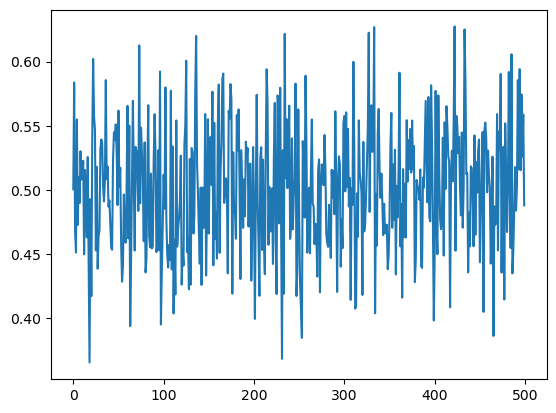

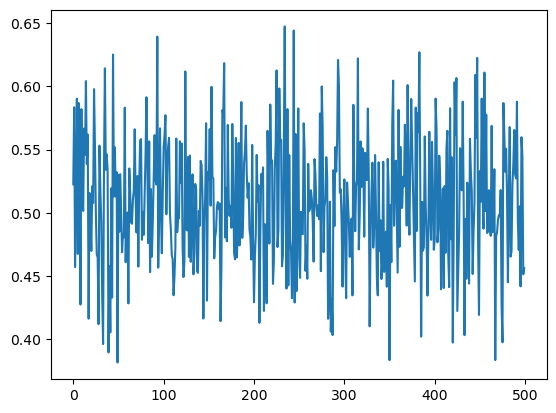

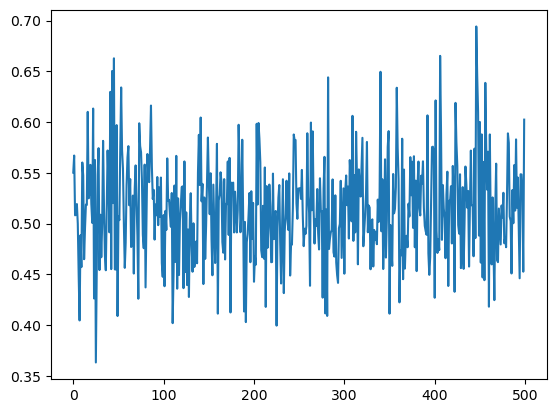

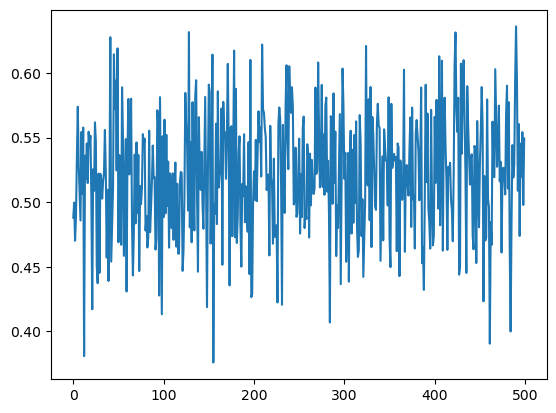

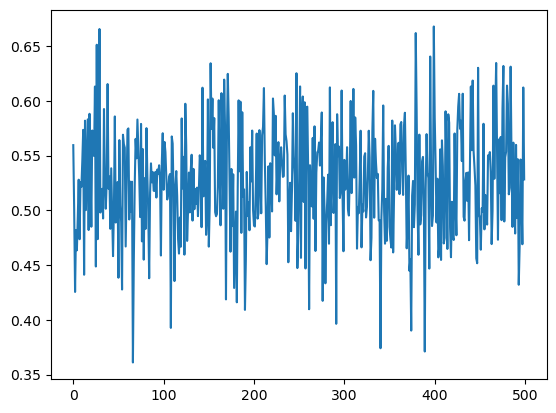

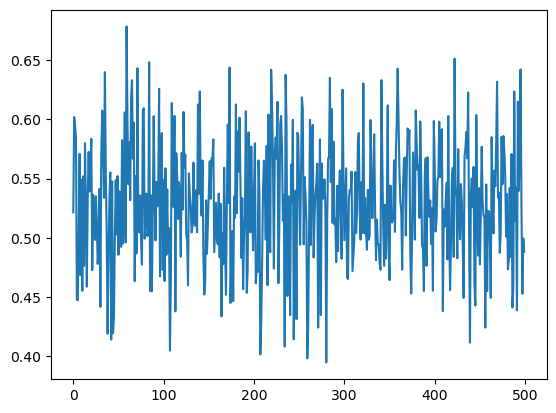

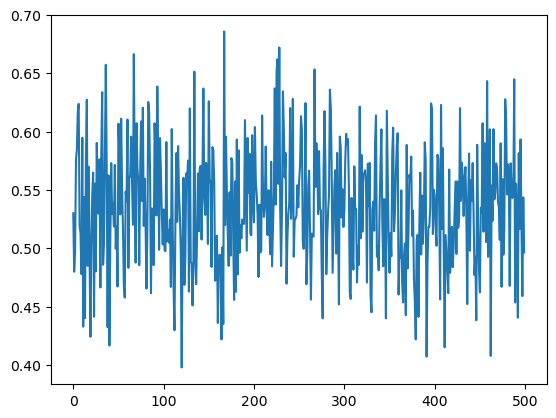

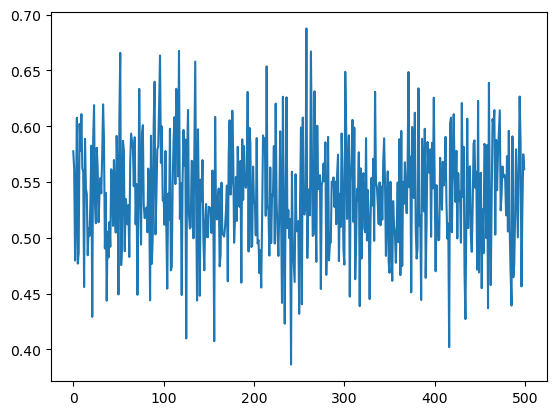

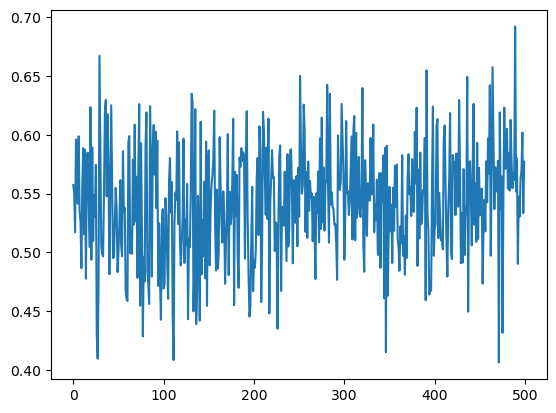

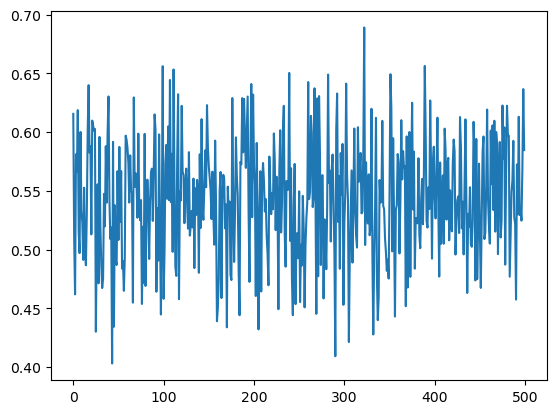

In [308]:
#plot batch accuracy for each epoch pt 1
for epoch in range(num_epochs):
    plt.plot(train[epoch], linestyle = "-")
    plt.show()

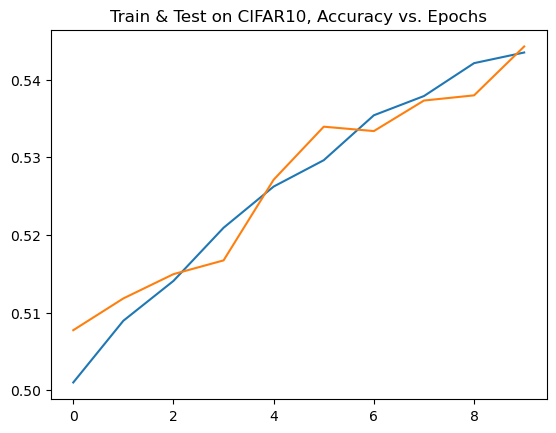

In [310]:
#plot batch accuracy for each epoch pt 2
train_averages = [sum(e)/len(e) for e in train]
test_averages = [sum(e)/len(e) for e in test]
plt.plot(train_averages)
plt.plot(test_averages)
plt.title("Train & Test on CIFAR10, Accuracy vs. Epochs")
plt.show()

In [159]:
torch.save(model, "model/CIFAR_real_deepNN.pth")

In [141]:
#Load the saved model
model = torch.load("model/CIFAR_real_deepNN.pth", weights_only=False)
model.eval()

DeepCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [143]:
#PRINTING PROBABILITIES ALONG THE MODEL TRAINING CYCLES
#Find the batch number  (value between 0 and 499) and an image record within a batch (0 to 99)
#bat_num = 6 #which batch?
#img_ind = 80 #which image within the batch?

#In the last epoch b[9], check the value of output probs and get the max probability index (class)
#max_prb_index = np.argmax(b[9][bat_num].detach().numpy()[img_ind])
#print(max_prb_index)

#For all epochs for this record, check the probability in the specific class with the max prob index
#probs = []
#for epoch in <output from train model function>:
#    bat = epoch[bat_num]
#    img = bat.detach().numpy()[img_ind]
#    prb_val = img[max_prb_index]
#    probs.append(prb_val)

#plot probs
#print(probs)
#print probabilities through training epochs
#plt.plot(probs, linestyle="-")
#plt.show()

In [63]:
# Plot DeepCNN loss values
#plt.plot(b)
#plt.show()

In [105]:
#dir = os.fsdecode("data/archive/test/FAKE/")

#for file in os.listdir(dir):
#    file_src = os.fsdecode(file)
#    for i in range(3, 11):
#        if file_src.endswith(f"({i}).jpg"):
#            src = "data/archive/test/FAKE/" + file_src
#            dst = f"data/archive/test/FAKE/{i}/"
#            new_path = shutil.move(src, dst)
#            print(os.path.abspath(new_path))


#for file in os.listdir(dir):
#    file_src = os.fsdecode(file)
#    if file_src.endswith(".jpg"):
#        src = "data/archive/test/FAKE/" + file_src
#        dst = "data/archive/test/FAKE/1/"
#        new_path = shutil.move(src, dst)
#        print(os.path.abspath(new_path))

In [163]:
#test the model on fake data

fk_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/test/FAKE', transform=transform)
fk_test_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./data/archive/test/FAKE
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [312]:
#fk_test_loader = torch.utils.data.DataLoader(dataset=fk_test_dataset, batch_size=batch_size, shuffle=False)
#test_model(model, fk_test_loader)